In [ ]:
from utils import *

In [97]:
# Load the train/val split from the pickle file
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert DataFrames to list
train_texts = data['x_train']['text'].tolist()
val_texts = data['x_val']['text'].tolist()

# Convert Series to list and ensure labels are strings
train_labels = [str(label) for label in data['y_train'].tolist()]
val_labels = [str(label) for label in data['y_val'].tolist()]

# Check
print("Train samples:", len(train_texts), len(train_labels))
print("Validation samples:", len(val_texts), len(val_labels))

Train samples: 7630 7630
Validation samples: 1909 1909


## **2.1** RoBERTa (Encoder)

### **2.1.1** Setup

In [ ]:
# Load RoBERTa tokenizer and model (no sentiment head)
model_checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

### **2.1.2** Train and Validate

In [ ]:
# Define metrics
def trainer_compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                   # Where model checkpoints and logs go
    learning_rate=2e-5,                       # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,           # Small enough for most GPUs
    per_device_eval_batch_size=32,            # Larger eval batch size is okay for speed
    num_train_epochs=4,                       # 4 epochs — sufficient for many transformer tasks
    weight_decay=0.01,                        # Regularization to avoid overfitting
    logging_dir="./logs",                     # Logs directory
    logging_steps=100,                        # Log every 100 steps
    eval_strategy="epoch",                    # Evaluate at the end of every epoch
    save_strategy="epoch",                    # Save model at the end of every epoch
    load_best_model_at_end=True,              # Keep best model based on metric
    metric_for_best_model="f1",               # Use F1 to choose the best model
    greater_is_better=True,                   # Because higher F1 is better
    report_to=[]                              # Disable WandB or other loggers
)

# Data collator for truncation and padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    compute_metrics=trainer_compute_metrics
)

# Train the model
trainer.train()

# Save model and tokenizer
trainer.save_model("roberta-market-sentiment")
tokenizer.save_pretrained("roberta-market-sentiment")

Epoch,Training Loss,Validation Loss


In [ ]:
# Evaluate on training set
train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
print("\nTraining Set Evaluation Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

# Evaluate on validation set
val_metrics = trainer.evaluate(eval_dataset=dataset["validation"])
print("\nValidation Set Evaluation Metrics:")
for key, value in val_metrics.items():
    print(f"{key}: {value:.4f}")

### **2.1.3** Predict Test

In [ ]:
# Load the test set
test_data = pd.read_csv("test.csv")

In [ ]:
# Prepare the Hugging Face Dataset
test_ds = Dataset.from_dict({"text": test_data["text"].tolist()})
test_ds = test_ds.map(tokenize, batched=True)

# Predict labels
predictions = trainer.predict(test_dataset=test_ds)
pred_labels = predictions.predictions.argmax(-1)

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
# Create submission file
submission_roberta_enc = pd.DataFrame({
    "id": test_data["id"],
    "label": pred_labels
})

# Save submission
submission.to_csv("roberta_enc_pred_25.csv", index=False)

In [ ]:
pred_25 = pd.read_csv("pred_25.csv")
pred_25.head()

,id,label
0,0,1
1,1,2
2,2,2
3,3,1
4,4,2


## **2.2** GPT-4o (Decoder)

### **2.2.1** Setup

In [98]:
# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [99]:
# Function to classify texts using GPT-4o with few-shot examples
def classify_with_gpt4o_fewshot(texts, label_options, few_shot_examples=None,
                                delay=1.0, deployment="gpt-4o", batch_size=16):
    
    predictions = []
    # Calculate the number of batches
    num_batches = math.ceil(len(texts) / batch_size)

    # System prompt
    system_prompt = (
        f"You are a text classification assistant. You are analyzing short social media texts (tweets) "
        f"and classifying them into one of the following categories: {', '.join(map(str, label_options))}. "
        f"Respond only with the correct category label — no explanation."
    )

    for i in tqdm(range(num_batches), desc="Classifying with GPT-4o"):
        # Get the current batch of texts
        batch_texts = texts[i*batch_size : (i+1)*batch_size]

        for text in batch_texts:
            messages = [{"role": "system", "content": system_prompt}]

            # Add few-shot examples
            if few_shot_examples:
                for example in few_shot_examples:
                    messages.append({"role": "user", "content": example['text']})
                    messages.append({"role": "assistant", "content": example['label']})

            # Add actual input
            messages.append({"role": "user", "content": text})

            try:
                # Call the Azure OpenAI API
                response = client.chat.completions.create(
                    model=deployment,
                    messages=messages,
                    max_tokens=10,
                    temperature=0
                )
                output = response.choices[0].message.content.strip()
            except Exception as e:
                print(f"Error on input '{text[:30]}...': {e}")
                output = "unknown" # Fallback in case of error

            # Append the output to predictions
            predictions.append(output)
            # Delay to avoid hitting rate limits
            time.sleep(delay)

    return predictions

In [100]:
# Function to cache or run classification with gpt-4o with few-shot examples
def cached_classification_run(filename, texts, label_options, few_shot_examples=None,
                              delay=1.0, deployment="gpt-4o", force_reload=False, batch_size=16):
    
    # If the cache file exists and force_reload is False, load from cache
    if not force_reload and os.path.exists(filename):
        print(f"Loading cached results from {filename}")
        with open(filename, "rb") as f:
            predictions = pickle.load(f)
    # Otherwise, run classification and save to cache
    else:
        print(f"{'Force reload enabled.' if force_reload else 'No cache found.'} Running classification and saving to {filename}")
        # Get predictions using the classification function
        predictions = classify_with_gpt4o_fewshot(
            texts, label_options, few_shot_examples=few_shot_examples,
            delay=delay, deployment=deployment, batch_size=batch_size
        )
        # Save predictions to cache
        with open(filename, "wb") as f:
            pickle.dump(predictions, f)

    return predictions

### **2.2.2** Predict and Validate

In [101]:
# For reproducibility
random.seed(42)

# Label options
label_options = sorted(list(set(train_labels)))

# Generate few-shot examples
few_shot_examples = []
for label in label_options:
    examples = [(t, l) for t, l in zip(train_texts, train_labels) if l == label]
    sample = random.choice(examples)
    few_shot_examples.append({'text': sample[0], 'label': sample[1]})

# Print few-shot examples
print("Few-shot examples:")
for example in few_shot_examples:
    print(f"Text: {example['text']}, Label: {example['label']}")

Few-shot examples:
Text: employee furlough retail industry well million one america biggest clothing store, Label: 0
Text: coca cola break down record quarter, Label: 1
Text: would td bank benefit schwab ameritrade deal, Label: 2


In [103]:
# Run (or load cached) classification
train_gpt4o_preds = cached_classification_run("gpt4o_train_preds.pkl", train_texts, label_options, few_shot_examples, force_reload=False, batch_size=16)
val_gpt4o_preds = cached_classification_run("gpt4o_val_preds.pkl", val_texts, label_options, few_shot_examples, force_reload=False, batch_size=16)

# Labels
y_train = np.array(train_labels)
y_val = np.array(val_labels)

No cache found. Running classification and saving to gpt4o_train_preds.pkl


Classifying with GPT-4o: 100%|██████████| 1/1 [00:17<00:00, 17.08s/it]


No cache found. Running classification and saving to gpt4o_val_preds.pkl


Classifying with GPT-4o: 100%|██████████| 1/1 [00:17<00:00, 17.12s/it]


In [109]:
# Labels
y_train = np.array(train_labels)
y_val = np.array(val_labels)

# Labels
X_train_gpt40 = np.array(train_gpt4o_preds)
X_val_gpt40 = np.array(val_gpt4o_preds)

In [111]:
# Display metrics
metrics_gpt4o_df = get_metrics_df(
    "GPT-4o with with few-shot examples",
    train_labels, train_gpt4o_preds, val_labels, val_gpt4o_preds
)
metrics_gpt4o_df

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,GPT-4o with with few-shot examples,0.3926,0.3056,0.5111,0.2222,0.5952,0.5,0.4,0.3


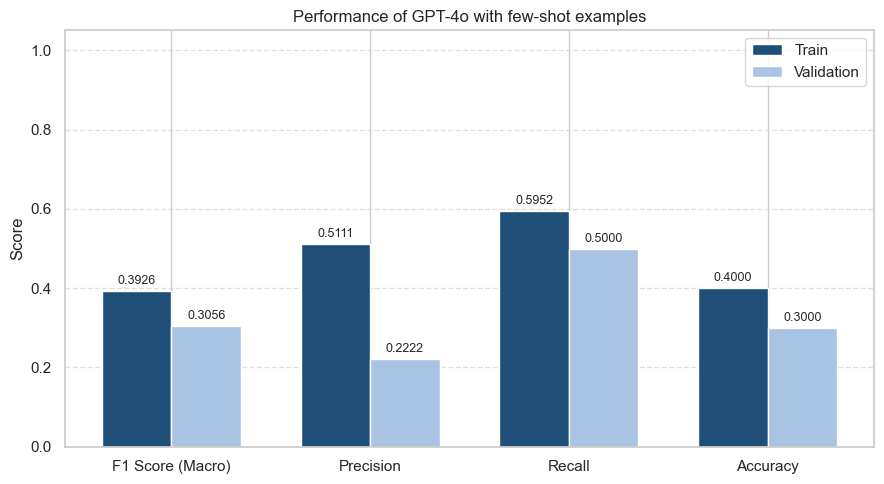

In [112]:
# Plot metrics
plot_metrics(train_labels, train_gpt4o_preds, val_labels, val_gpt4o_preds, title="Performance of GPT-4o with few-shot examples")

### **2.2.3** Predict Test

In [113]:
# Load the test dataset
test_data = pd.read_csv("../data/test.csv")
test_texts = test_data["text"].tolist()

In [115]:
# Predict labels with GPT-4o on the test set
test_gpt4o_preds = cached_classification_run("gpt4o_test_preds.pkl", test_texts, label_options, few_shot_examples, force_reload=False, batch_size=16)

# Create submission DataFrame
submission_gpt4o = pd.DataFrame({
    "id": test_data["id"],
    "label": test_gpt4o_preds
})

# Save submission to CSV
submission_gpt4o.to_csv("gpt4o_pred_25.csv", index=False)
print("Submission file saved as gpt4o_pred_25.csv")

Loading cached results from gpt4o_test_preds.pkl
Submission file saved as gpt4o_pred_25.csv


In [116]:
# Load the predictions from the saved CSV file
pred_25 = pd.read_csv("gpt4o_pred_25.csv")
pred_25.head()

,id,label
0,0,1
1,1,1
2,2,1
3,3,0
4,4,2
